# Creation and training of ME-NeuralFMUs
Tutorial by Johannes Stoljar, Tobias Thummerer

## LICENSE


In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
The Julia Package *FMIFlux.jl* is motivated by the application of hybrid modeling. This package enables the user to integrate his simulation model between neural networks (NeuralFMU). For this, the simulation model must be exported as FMU (functional mock-up unit), which corresponds to a widely used standard. The big advantage of hybrid modeling with artificial neural networks is, that effects that are difficult to model (because they might be unknown) can be easily learned by the neural networks. For this purpose, the NeuralFMU is trained with measurement data containing the not modeled physical effect. The final product is a simulation model including the originally not modeled effects. Another big advantage of the NeuralFMU is that it works with little data, because the FMU already contains the characteristic functionality of the simulation and only the missing effects are added.

NeuralFMUs do not need to be as easy as in this example. Basically a NeuralFMU can combine different ANN topologies that manipulate any FMU-input (system state, system inputs, time) and any FMU-output (system state derivative, system outputs, other system variables). However, for this example a NeuralFMU topology as shown in the following picture is used.

![NeuralFMU.svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/NeuralFMU.svg?raw=true)

*NeuralFMU (ME) from* [[1]](#Source).

## Introduction to the example
In this example, simplified modeling of a one-dimensional spring pendulum (without friction) is compared to a model of the same system that includes a nonlinear friction model. The FMU with the simplified model will be named *simpleFMU* in the following and the model with the friction will be named *realFMU*. At the beginning, the actual state of both simulations is shown, whereby clear deviations can be seen in the graphs. The *realFMU* serves as a reference graph. The *simpleFMU* is then integrated into a NeuralFMU architecture and a training of the entire network is performed. After the training the final state is compared again to the *realFMU*. It can be clearly seen that by using the NeuralFMU, learning of the friction process has taken place.  


## Target group
The example is primarily intended for users who work in the field of first principle and/or hybrid modeling and are further interested in hybrid model building. The example wants to show how simple it is to combine FMUs with machine learning and to illustrate the advantages of this approach.


## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/advanced_hybrid_ME.ipynb) there is also a [Julia file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/advanced_hybrid_ME.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/advanced_hybrid_ME.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites
|     | Description                       | Command                   | Alternative                                    |   
|:----|:----------------------------------|:--------------------------|:-----------------------------------------------|
| 1.  | Enter Package Manager via         | ]                         |                                                |
| 2.  | Install FMI via                   | add FMI                   | add " https://github.com/ThummeTo/FMI.jl "     |
| 3.  | Install FMIFlux via               | add FMIFlux               | add " https://github.com/ThummeTo/FMIFlux.jl " |
| 4.  | Install FMIZoo via                | add FMIZoo                | add " https://github.com/ThummeTo/FMIZoo.jl "  |
| 5.  | Install Flux via                  | add Flux                  |                                                |
| 6.  | Install DifferentialEquations via | add DifferentialEquations |                                                |
| 7.  | Install Plots via                 | add Plots                 |                                                |
| 8.  | Install Random via                | add Random                |                                                |

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMI.FMIImport: fmi2StringToValueReference, fmi2ValueReference, fmi2Real
using FMIFlux
using FMIZoo
using Flux
using DifferentialEquations: Tsit5
using Statistics: mean, std
import Plots

# set seed
import Random
Random.seed!(1234);

After importing the packages, the path to the *Functional Mock-up Units* (FMUs) is set. The FMU is a model exported meeting the *Functional Mock-up Interface* (FMI) Standard. The FMI is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. 

The object-orientated structure of the *SpringPendulum1D* (*simpleFMU*) can be seen in the following graphic and corresponds to a simple modeling.

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/SpringPendulum1D.svg?raw=true)

In contrast, the model *SpringFrictionPendulum1D* (*realFMU*) is somewhat more accurate, because it includes a friction component. 

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/SpringFrictionPendulum1D.svg?raw=true)

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.1
tStop = 5.0
tSave = collect(tStart:tStep:tStop)

51-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 ⋮
 3.9
 4.0
 4.1
 4.2
 4.3
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0

### RealFMU

In the next lines of code the FMU of the *realFMU* model from *FMIZoo.jl* is loaded and the information about the FMU is shown.

In [4]:
realFMU = fmiLoad("SpringFrictionPendulum1D", "Dymola", "2022x")
fmiInfo(realFMU)

┌ Info: fmi2Unzip(...): Successfully unzipped 153 files at `/tmp/fmijl_0A4Cs7/SpringFrictionPendulum1D`.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:90
┌ Info: fmi2Load(...): FMU resources location is `file:////tmp/fmijl_0A4Cs7/SpringFrictionPendulum1D/resources`
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:221
┌ Info: fmi2Load(...): FMU supports both CS and ME, using CS as default if nothing specified.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:224


#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{2e178ad3-5e9b-48ec-a7b2-baa5669efc0c}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:12Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


In the function fmiSimulate() the *realFMU* is simulated, still specifying the start and end time, the parameters and which variables are recorded. After the simulation is finished the result of the *realFMU* can be plotted. This plot also serves as a reference for the other model (*simpleFMU*).

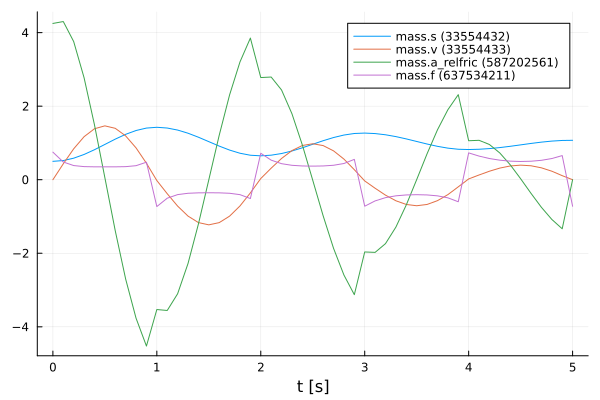

In [5]:
vrs = ["mass.s", "mass.v", "mass.a", "mass.f"]
realSimData = fmiSimulate(realFMU, tStart, tStop; recordValues=vrs, saveat=tSave)
fmiPlot(realSimData)

The data from the simulation of the *realFMU*, are divided into position and velocity data. These data will be needed later. 

In [6]:
posReal = fmi2GetSolutionValue(realSimData, "mass.s")
velReal = fmi2GetSolutionValue(realSimData, "mass.v")

51-element Vector{Float64}:
  0.0
  0.432852398300982
  0.8401743918610578
  1.1702254881462497
  1.3861768532456016
  1.4649609400224617
  1.397962181945595
  1.1917483098990418
  0.8657325133644009
  0.44821918384886916
 -0.02200493896693855
 -0.380560845401747
 -0.7172068753289351
  ⋮
 -0.19353187721088116
  0.021605187634145845
  0.12911473439606144
  0.2315130895115627
  0.31667721272388255
  0.37417576531479746
  0.3964197153211615
  0.3795927497483354
  0.3235539803194403
  0.2317738499958648
  0.11061350893737848
 -1.0008118292437196e-10

The FMU hase two states: The first state is the position of the mass and the second state is the velocity. The initial position of the mass is initilized with $0.5𝑚$. The initial velocity of the mass is initialized with $0\frac{m}{s}$. 

In [7]:
x₀ = [posReal[1], velReal[1]]

2-element Vector{Float64}:
 0.5
 0.0

After extracting the data, the FMU is cleaned-up.

In [8]:
fmiUnload(realFMU)

### SimpleFMU

The following lines load, simulate and plot the *simpleFMU* just like the *realFMU*. The differences between both systems can be clearly seen from the plots. In the plot for the *realFMU* it can be seen that the oscillation continues to decrease due to the effect of the friction. If you simulate long enough, the oscillation would come to a standstill in a certain time. The oscillation in the *simpleFMU* behaves differently, since the friction was not taken into account here. The oscillation in this model would continue to infinity with the same oscillation amplitude. From this observation the desire of an improvement of this model arises.     

#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{fc15d8c4-758b-48e6-b00e-5bf47b8b14e5}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:23Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


┌ Info: fmi2Unzip(...): Successfully unzipped 153 files at `/tmp/fmijl_ZNWQK6/SpringPendulum1D`.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:90
┌ Info: fmi2Load(...): FMU resources location is `file:////tmp/fmijl_ZNWQK6/SpringPendulum1D/resources`
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:221
┌ Info: fmi2Load(...): FMU supports both CS and ME, using CS as default if nothing specified.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/1Yngw/src/FMI2_ext.jl:224


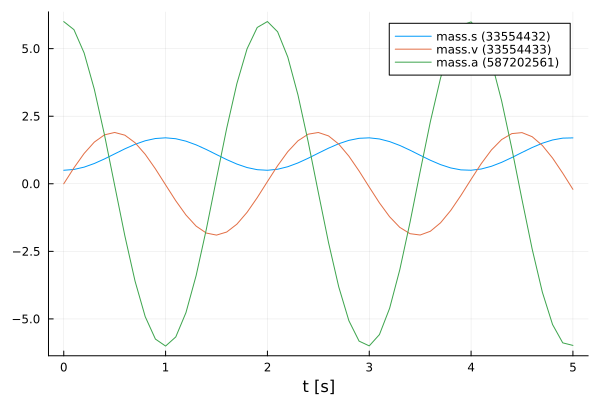

In [9]:
simpleFMU = fmiLoad("SpringPendulum1D", "Dymola", "2022x")
fmiInfo(simpleFMU)

vrs = ["mass.s", "mass.v", "mass.a"]
simpleSimData = fmiSimulate(simpleFMU, tStart, tStop; recordValues=vrs, saveat=tSave)
fmiPlot(simpleSimData)

The data from the simulation of the *simpleFMU*, are divided into position and velocity data. These data will be needed later to plot the results. 

In [10]:
posSimple = fmi2GetSolutionValue(simpleSimData, "mass.s")
velSimple = fmi2GetSolutionValue(simpleSimData, "mass.v")

51-element Vector{Float64}:
  0.0
  0.5899802196326744
  1.1216144329248279
  1.542195620662035
  1.810172737052044
  1.8985676043018223
  1.7983499725303025
  1.5196216961327944
  1.0900958349841172
  0.5523346620786151
 -0.040261546913912205
 -0.6289411637396933
 -1.1552195220019175
  ⋮
 -0.43297835247721894
  0.1644403574466082
  0.7455652283389829
  1.2527659117804728
  1.6356623403044424
  1.8562751551367387
  1.8926761758140136
  1.7412508664862896
  1.417004896988811
  0.9521088322603164
  0.3926807653512623
 -0.20575332570677826

## NeuralFMU

#### Loss function with growing horizon

In order to train our model, a loss function must be implemented. The solver of the NeuralFMU can calculate the gradient of the loss function. The gradient descent is needed to adjust the weights in the neural network so that the sum of the error is reduced and the model becomes more accurate.

The loss function in this implementation consists of the mean squared error (mse) from the real position of the *realFMU* simulation (posReal) and the position data of the network (posNet).
$$ mse = \frac{1}{n} \sum\limits_{i=0}^n (posReal[i] - posNet[i])^2 $$
A growing horizon is applied, whereby the horizon only goes over the first five values. For this horizon the mse is calculated.

In [11]:
# loss function for training
global horizon = 5
function lossSum(p)
    global posReal, neuralFMU, horizon
    solution = neuralFMU(x₀, tStart; p=p)

    posNet = fmi2GetSolutionState(solution, 1; isIndex=true)
    
    horizon = min(length(posNet), horizon)

    Flux.Losses.mse(posReal[1:horizon], posNet[1:horizon])
end

lossSum (generic function with 1 method)

#### Function for plotting

In this section the function for plotting is defined. The function `plotResults()` creates a new figure object. In dieses figure objekt werden dann die aktuellsten Ergebnisse von *realFMU*, *simpleFMU* und *neuralFMU* gegenübergestellt. 

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every twentieth pass the loss function is called and the average error is printed out.

In [12]:
function plotResults()
    global neuralFMU
    solution = neuralFMU(x₀, tStart)

    posNeural = fmi2GetSolutionState(solution, 1; isIndex=true)
    time = fmi2GetSolutionTime(solution)
    
    fig = Plots.plot(xlabel="t [s]", ylabel="mass position [m]", linewidth=2,
                     xtickfontsize=12, ytickfontsize=12,
                     xguidefontsize=12, yguidefontsize=12,
                     legendfontsize=8, legend=:topright)
    
    Plots.plot!(fig, tSave, posSimple, label="SimpleFMU", linewidth=2)
    Plots.plot!(fig, tSave, posReal, label="RealFMU", linewidth=2)
    Plots.plot!(fig, time, posNeural, label="NeuralFMU", linewidth=2)
    fig
end

plotResults (generic function with 1 method)

#### Callback

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every twentieth pass the loss function is called and the average error is printed out.  As soon as a limit value (in this example `0.1`) is undershot, the horizon is extended by the next two values.

In [13]:
# callback function for training
global counter = 0
function callb(p)
    global counter, horizon 
    counter += 1
   
    if counter % 20 == 1
        avgLoss = lossSum(p[1])
        @info "   Loss [$counter] for horizon $horizon : $(round(avgLoss, digits=5))   
        Avg displacement in data: $(round(sqrt(avgLoss), digits=5))"
        
        if avgLoss <= 0.01
            horizon += 2
        end
   
        # fig = plotResults()
        # println("Figure update.")
        # display(fig)
    end
end


callb (generic function with 1 method)

#### Pre- and Postprocessing

In the following functions for pre-processing and post-processing are defined. The function `preProc` is normalized the input values to mean of zero and a standard deviation of one. 

In [14]:
global meanVal = 0.0
global stdVal = 0.0

function preProc!(data)
    global meanVal, stdVal

    meanVal = mean(data)
    stdVal = std(data)
    
    (data .- meanVal) ./ stdVal    
end 

preProc! (generic function with 1 method)

For post-processing, the previous normalization is undone by applying the calculation steps in reverse order.

In [15]:
function postProc!(data)
    global meanVal, stdVal
    
    (data .* stdVal) .+ meanVal
end 

postProc! (generic function with 1 method)

#### Structure of the NeuralFMU

In the following, the topology of the NeuralFMU is constructed. It consists of an input layer, which then leads into the *simpleFMU* model. The ME-FMU computes the state derivatives for a given system state. Following the *simpleFMU* is a dense layer that has exactly as many inputs as the model has states (and therefore state derivatives). The output of this layer consists of 16 output nodes and a *tanh* activation function. The next layer has 16 input and output nodes with the same activation function. The last layer is again a dense layer with 16 input nodes and the number of states as outputs. Here, it is important that no *tanh*-activation function follows, because otherwise the pendulums state values would be limited to the interval $[-1;1]$.

In [16]:
# NeuralFMU setup
numStates = fmiGetNumberOfStates(simpleFMU)
additionalVRs = [fmi2StringToValueReference(simpleFMU, "mass.m")]
numAdditionalVRs = length(additionalVRs)

net = Chain(
    inputs -> fmiEvaluateME(simpleFMU, inputs, -1.0, zeros(fmi2ValueReference, 0), 
                            zeros(fmi2Real, 0), additionalVRs),
    preProc!,
    Dense(numStates+numAdditionalVRs, 16, tanh),
    postProc!,
    preProc!,
    Dense(16, 16, tanh),
    postProc!,
    preProc!,
    Dense(16, numStates),
    postProc!,
)

Chain(
  var"#1#2"(),
  preProc!,
  Dense(3 => 16, tanh),                 # 64 parameters
  postProc!,
  preProc!,
  Dense(16 => 16, tanh),                # 272 parameters
  postProc!,
  preProc!,
  Dense(16 => 2),                       # 34 parameters
  postProc!,
)                   # Total: 6 arrays, 370 parameters, 1.820 KiB.

#### Definition of the NeuralFMU

The instantiation of the ME-NeuralFMU is done as a one-liner. The FMU (*simpleFMU*), the structure of the network `net`, start `tStart` and end time `tStop`, the numerical solver `Tsit5()` and the time steps `tSave` for saving are specified.

In [17]:
neuralFMU = ME_NeuralFMU(simpleFMU, net, (tStart, tStop), Tsit5(); saveat=tSave);

┌ Info: ME_NeuralFMU(...): Succesfully converted layer of type `Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}` to `Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}`.
└ @ FMIFlux /home/runner/.julia/packages/FMIFlux/WeryT/src/FMI_neural.jl:1089
┌ Info: ME_NeuralFMU(...): Succesfully converted layer of type `Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}` to `Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}`.
└ @ FMIFlux /home/runner/.julia/packages/FMIFlux/WeryT/src/FMI_neural.jl:1089
┌ Info: ME_NeuralFMU(...): Succesfully converted layer of type `Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}` to `Dense{typeof(identity), Matrix{Float64}, Vector{Float64}}`.
└ @ FMIFlux /home/runner/.julia/packages/FMIFlux/WeryT/src/FMI_neural.jl:1089
┌ Info: ME_NeuralFMU(...): Succesfully converted model to Float64.
└ @ FMIFlux /home/runner/.julia/packages/FMIFlux/WeryT/src/FMI_neural.jl:1103


#### Plot before training

Here the state trajectory of the *simpleFMU* is recorded. Doesn't really look like a pendulum yet, but the system is random initialized by default. In the plots later on, the effect of learning can be seen.

Simulating ME-NeuralFMU ... 100%|████████████████████████| Time: 0:00:23


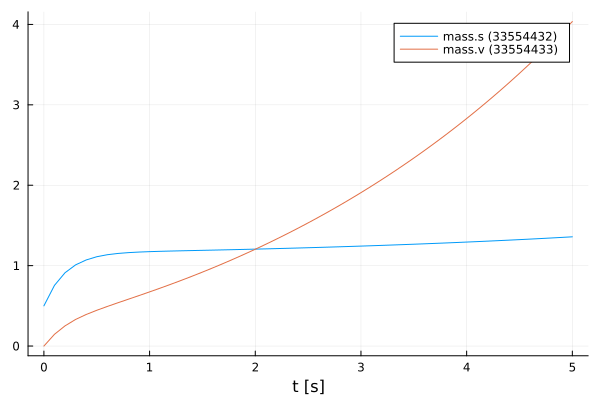

In [18]:
solutionBefore = neuralFMU(x₀, tStart)
fmiPlot(solutionBefore)

#### Training of the NeuralFMU

For the training of the NeuralFMU the parameters are extracted. The known ADAM optimizer for minimizing the gradient descent is used as further passing parameters. In addition, the previously defined loss and callback function, as well as the number of epochs are passed.

In [19]:
# train
paramsNet = Flux.params(neuralFMU)

optim = ADAM()
FMIFlux.train!(lossSum, paramsNet, Iterators.repeated((), 1000), optim; cb=()->callb(paramsNet)) 

Simulating ME-NeuralFMU ... 100%|████████████████████████| Time: 0:00:21
┌ Info:    Loss [1] for horizon 5 : 0.06331   
│         Avg displacement in data: 0.25162
└ @ Main In[13]:9
┌ Info:    Loss [21] for horizon 5 : 0.00542   
│         Avg displacement in data: 0.0736
└ @ Main In[13]:9
┌ Info:    Loss [41] for horizon 7 : 0.00257   
│         Avg displacement in data: 0.05067
└ @ Main In[13]:9
┌ Info:    Loss [61] for horizon 9 : 0.00295   
│         Avg displacement in data: 0.05433
└ @ Main In[13]:9
┌ Info:    Loss [81] for horizon 11 : 0.00074   
│         Avg displacement in data: 0.02722
└ @ Main In[13]:9
┌ Info:    Loss [101] for horizon 13 : 0.00286   
│         Avg displacement in data: 0.0535
└ @ Main In[13]:9
┌ Info:    Loss [121] for horizon 15 : 0.00705   
│         Avg displacement in data: 0.08397
└ @ Main In[13]:9
┌ Info:    Loss [141] for horizon 17 : 0.01516   
│         Avg displacement in data: 0.12313
└ @ Main In[13]:9
┌ Info:    Loss [161] for horizon 17 : 0.00

#### Comparison of the plots

Here three plots are compared with each other and only the position of the mass is considered. The first plot represents the *simpleFMU*, the second represents the *realFMU* (reference) and the third plot represents the result after training the NeuralFMU. 

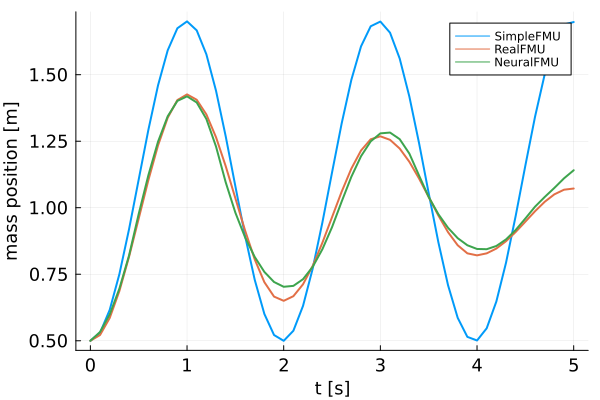

In [20]:
# plot results mass.s
plotResults()

Finally, the FMU is cleaned-up.

In [21]:
fmiUnload(simpleFMU)

### Summary

Based on the plots, it can be seen that the NeuralFMU is able to adapt the friction model of the *realFMU*. After 300 runs, the curves do not overlap very well, but this can be achieved by longer training (1000 runs) or a better initialization.

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)
